# 3D Molecular Analysis and Docking Pipeline

This notebook performs a complete 3D molecular analysis pipeline including:
- Conformer generation and energy minimization
- Distance matrix (distogram) and RMSD analysis
- SuCOS similarity scoring
- Boltzmann probability weighting
- Molecular docking with AutoDock Vina
- Results comparison and visualization

## Dataset
We analyze a set of HIV protease inhibitors and simple alcohols, comparing their binding to the HIV-1 protease (PDB: 1HSG).

In [10]:
# Required packages
# Install via pip or conda
# pip install rdkit-pypi numpy scipy matplotlib pandas py3Dmol openbabel vina

import os
import numpy as np
import pandas as pd
from rdkit import Chem, RDConfig
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, rdShapeHelpers, rdmolfiles
from rdkit.Chem.FeatMaps import FeatMaps
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import requests

# Optional visualization
import py3Dmol

# Docking (uncomment if vina is installed)
# from vina import Vina  # AutoDock Vina Python API

print("All libraries imported successfully!")

All libraries imported successfully!


---
## Task 1: Generate 3D Conformers for Ligands

### Description
Generate multiple 3D conformers for each ligand molecule using RDKit's conformer generation.

**Steps:**
1. Parse SMILES strings to RDKit molecule objects
2. Add hydrogens to molecules
3. Generate multiple conformers using `EmbedMultipleConfs`
4. Energy minimize each conformer using MMFF force field
5. Store energies for later Boltzmann weighting

In [11]:
# Ligand SMILES dictionary
ligand_smiles = {
    "ethanol": "CCO",
    "isopropanol": "CC(C)O",
    "phenol": "C1=CC=CC=C1O",
    # "darunavir": "CC(C)(C)OC(=O)N[C@H]1CC[C@H](NC(=O)[C@H](C[C@@H]2Cc3ccc(cc3O2)O)NC(=O)C2CCCN2C(=O)[C@H]2Cc3ccc(cc3O2)O)C(=O)N1C",
    "tipranavir": "CCC[C@]1(CC(/O)=C(\\C(=O)O1)[C@H](CC)c3cccc(NS(=O)(=O)c2ccc(cn2)C(F)(F)F)c3)CCc4ccccc4",
    # "nelfinavir": "CC(C)C1=NC[C@H]2[C@@H](C[C@@H]2C(=O)N(C)[C@@H]1C[C@@H](C)NC(=O)[C@@H]1CC[C@H](C)CC1)c1ccccc1O",
    # "lopinavir": "O=C(N[C@@H](Cc1ccccc1)[C@@H](O)C[C@@H](NC(=O)[C@@H](NC2C(=O)NCCC2)C(C)C)Cc3ccccc3)COc4c(cccc4C)C",
    # "saquinavir": "O=C(N)C[C@H](NC(=O)c1nc2c(cc1)cccc2)C(=O)N[C@@H](Cc3ccccc3)[C@H](O)CN5[C@H](C(=O)NC(C)(C)C)C[C@@H]4CCCC[C@@H]4C5",
}

protein_pdb_code = "1HSG"

print(f"Number of ligands: {len(ligand_smiles)}")
print(f"Target protein: {protein_pdb_code}")

Number of ligands: 4
Target protein: 1HSG


In [12]:
def show_structure(pdb_str, style='stick', width=500, height=400):
    """Visualize a PDB string in 3D using py3Dmol"""
    view = py3Dmol.view(width=width, height=height)
    view.addModel(pdb_str, 'pdb')
    view.setStyle({style:{}})
    view.zoomTo()
    return view.show()

In [9]:
# Generate 20 conformers per ligand
n_confs = 20

ligands = {}
for name, smi in ligand_smiles.items():
    print(f"Processing {name}...")
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        print(f"  Failed to parse SMILES for {name}")
        continue
    
    mol = Chem.AddHs(mol)  # Add hydrogens
    
    # Generate conformers
    ids = AllChem.EmbedMultipleConfs(
        mol, 
        numConfs=n_confs, 
        useExpTorsionAnglePrefs=True, 
        useBasicKnowledge=True,
        randomSeed=42
    )
    
    if len(ids) == 0:
        print(f"  Failed to generate conformers for {name}")
        continue
    
    # Energy minimize each conformer
    energies = []
    for conf_id in ids:
        props = AllChem.MMFFGetMoleculeProperties(mol)
        if props is None:
            energies.append(float('inf'))
            continue
        ff = AllChem.MMFFGetMoleculeForceField(mol, props, confId=conf_id)
        if ff is None:
            energies.append(float('inf'))
            continue
        ff.Minimize()
        energies.append(ff.CalcEnergy())
    
    ligands[name] = {
        'mol': mol, 
        'confs': list(ids), 
        'energies': np.array(energies)
    }
    print(f"  Generated {len(ids)} conformers, energies range: {min(energies):.2f} - {max(energies):.2f} kcal/mol")

print(f"\nSuccessfully processed {len(ligands)} ligands")

Processing ethanol...
  Generated 20 conformers, energies range: -1.52 - -1.34 kcal/mol
Processing isopropanol...
  Generated 20 conformers, energies range: 1.00 - 1.17 kcal/mol
Processing phenol...
  Generated 20 conformers, energies range: 5.71 - 5.71 kcal/mol
Processing tipranavir...
  Generated 20 conformers, energies range: 119.76 - 138.06 kcal/mol

Successfully processed 4 ligands


In [25]:
# Visualize first conformer of darunavir
if 'tipranavir' in ligands:
    mol = ligands['tipranavir']['mol']
    conf_id = ligands['tipranavir']['confs'][1]
    
    # Export conformer to PDB string
    pdb_str = rdmolfiles.MolToPDBBlock(mol, confId=conf_id)
    print("Visualizing first conformer of Darunavir:")
    show_structure(pdb_str)

Visualizing first conformer of Darunavir:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

---
## Task 2: Compute Distograms and RMSD Matrix

### Description
Analyze conformational flexibility by computing:
1. **Distograms**: Pairwise distance matrices between all atoms for each conformer
2. **RMSD Matrix**: Root-mean-square deviation between all pairs of conformers

These metrics help quantify molecular flexibility - larger variations indicate more flexible molecules.

In [14]:
def compute_distogram(mol, conf_id):
    """Compute pairwise distance matrix (distogram) for a conformer"""
    conf = mol.GetConformer(conf_id)
    n_atoms = mol.GetNumAtoms()
    coords = np.array([list(conf.GetAtomPosition(i)) for i in range(n_atoms)])
    dist_matrix = squareform(pdist(coords))
    return dist_matrix


def compute_rmsd_matrix(mol, conf_ids):
    """RMSD between all conformers"""
    n = len(conf_ids)
    rmsd_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            rmsd = rdMolAlign.GetBestRMS(mol, mol, prbId=conf_ids[i], refId=conf_ids[j])
            rmsd_mat[i, j] = rmsd
            rmsd_mat[j, i] = rmsd
    return rmsd_mat


def plot_matrix(matrix, title, filename=None):
    """Plot a matrix as a heatmap"""
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title(title)
    plt.xlabel('Index')
    plt.ylabel('Index')
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

In [26]:
# Calculate RMSD and distograms for each ligand
print("Computing RMSD matrices and distograms...\n")

for name, data in ligands.items():
    print(f"Processing {name}...")
    mol = data['mol']
    conf_ids = data['confs']
    
    # RMSD matrix
    rmsd_mat = compute_rmsd_matrix(mol, conf_ids)
    data['rmsd_matrix'] = rmsd_mat
    
    # Distograms for all conformers
    distograms = np.array([compute_distogram(mol, cid) for cid in conf_ids])
    data['distograms'] = distograms
    
    # Mean distogram distance matrix norm (flexibility measure)
    mean_distogram = np.mean(distograms, axis=0)
    std_distogram = np.std(distograms, axis=0)
    data['mean_distogram'] = mean_distogram
    data['mean_distogram_norm'] = np.linalg.norm(std_distogram)
    
    # RMSD-based flexibility (Frobenius norm of RMSD matrix)
    data['rmsd_flex'] = np.linalg.norm(rmsd_mat)
    
    print(f"  RMSD flexibility: {data['rmsd_flex']:.3f}")
    print(f"  Distogram std norm: {data['mean_distogram_norm']:.3f}")

print("\nDone!")

Computing RMSD matrices and distograms...

Processing ethanol...
  RMSD flexibility: 6.606
  Distogram std norm: 1.758
Processing isopropanol...
  RMSD flexibility: 6.229
  Distogram std norm: 3.570
Processing phenol...
  RMSD flexibility: 0.000
  Distogram std norm: 1.660
Processing tipranavir...
  RMSD flexibility: 68.619
  Distogram std norm: 106.748

Done!


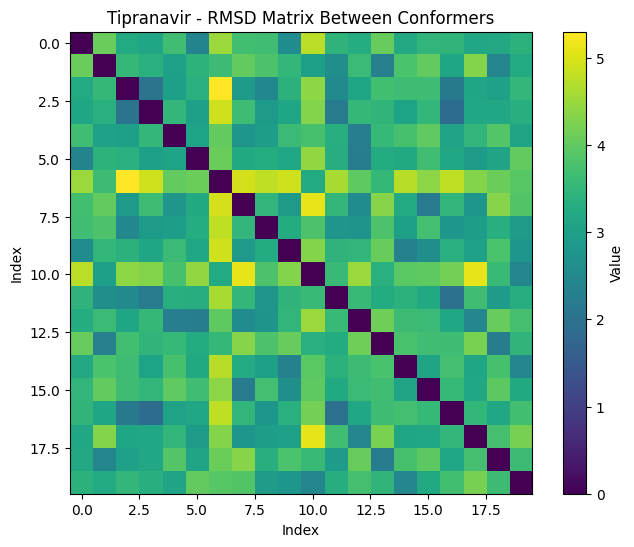

In [16]:
# Plot RMSD matrix for tipranavir
if 'tipranavir' in ligands:
    plot_matrix(
        ligands['tipranavir']['rmsd_matrix'], 
        'Tipranavir - RMSD Matrix Between Conformers',
        'tipranavir_rmsd_matrix.png'
    )

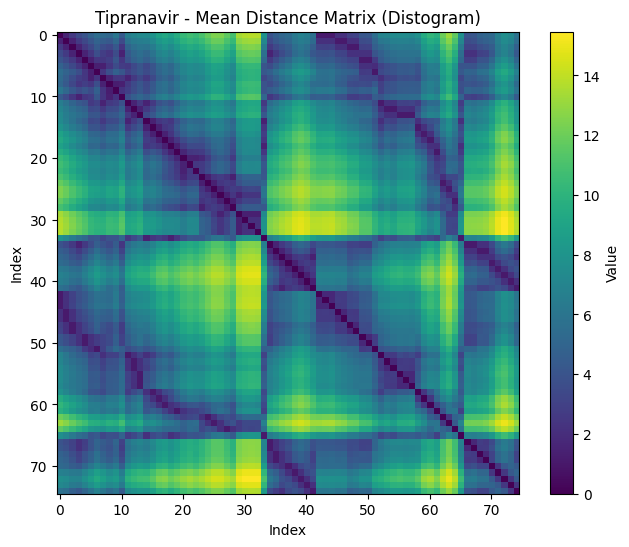

In [17]:
# Plot mean distogram for tipranavir
if 'tipranavir' in ligands:
    plot_matrix(
        ligands['tipranavir']['mean_distogram'], 
        'Tipranavir - Mean Distance Matrix (Distogram)',
        'tipranavir_mean_distogram.png'
    )

---
## Task 3: Compute SuCOS Similarity Scores

### Description
**SuCOS (Surface Complementarity Score)** measures the similarity between two molecular conformers based on:
1. **Feature map score**: Overlap of pharmacophoric features (donors, acceptors, aromatics, etc.)
2. **Shape protrusion distance**: How well the molecular shapes overlap

SuCOS = 0.5 × feature_score + 0.5 × (1 - protrusion_distance)

Values range from 0 (no similarity) to 1 (identical).

In [18]:
def mol_with_conformer(mol, conf_id):
    """
    Create a copy of molecule with only the specified conformer.
    This is needed because RDKit shape functions use the first conformer by default.
    
    Args:
        mol: RDKit molecule with multiple conformers
        conf_id: ID of the conformer to keep
    
    Returns:
        RDKit Mol: New molecule with only the specified conformer
    """
    new_mol = Chem.Mol(mol)
    # Get the conformer we want to keep
    conf = mol.GetConformer(conf_id)
    # Remove all conformers from the new molecule
    new_mol.RemoveAllConformers()
    # Add back only the conformer we want (it will become conformer 0)
    new_mol.AddConformer(Chem.Conformer(conf), assignId=True)
    return new_mol


def get_SuCOS_score(ref_mol, query_mol):
    """
    Compute SuCOS score between two molecules (using their first conformers).
    
    SuCOS = 0.5 * feature_map_score + 0.5 * (1 - protrusion_distance)
    
    Args:
        ref_mol: Reference molecule (uses first conformer)
        query_mol: Query molecule (uses first conformer)
    
    Returns:
        float: SuCOS score between 0 and 1
    """
    # Build feature factory
    fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))
    
    # Feature map parameters
    fmParams = {}
    for k in fdef.GetFeatureFamilies():
        fparams = FeatMaps.FeatMapParams()
        fmParams[k] = fparams
    
    # Features to keep
    keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
            'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')
    
    # Get features for both molecules
    featLists = []
    for m in [ref_mol, query_mol]:
        rawFeats = fdef.GetFeaturesForMol(m)
        # Filter to only include features we're interested in
        featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    
    # Create feature maps
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    fms[0].scoreMode = FeatMaps.FeatMapScoreMode.All
    
    # Calculate feature map score
    if fms[0].GetNumFeatures() == 0 or len(featLists[1]) == 0:
        fm_score = 0.0
    else:
        fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
        fm_score = np.clip(fm_score, 0, 1)
    
    # Calculate shape protrusion distance
    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref_mol, query_mol, allowReordering=False)
    protrude_dist = np.clip(protrude_dist, 0, 1)
    
    # Combine scores
    SuCOS_score = 0.5 * fm_score + 0.5 * (1 - protrude_dist)
    
    return SuCOS_score


def compute_sucos_matrix(mol, conf_ids):
    """
    Compute SuCOS similarity matrix between all conformer pairs.
    
    For each pair of conformers, creates temporary molecule copies with 
    only that specific conformer, then computes SuCOS score.
    
    Args:
        mol: RDKit molecule with multiple conformers
        conf_ids: List of conformer IDs
    
    Returns:
        np.array: Symmetric matrix of SuCOS scores
    """
    n = len(conf_ids)
    sucos_mat = np.zeros((n, n))
    
    # Diagonal is 1 (self-similarity)
    np.fill_diagonal(sucos_mat, 1.0)
    
    for i in range(n):
        for j in range(i+1, n):
            try:
                # Create temporary molecules with only the specific conformers
                mol_i = mol_with_conformer(mol, conf_ids[i])
                mol_j = mol_with_conformer(mol, conf_ids[j])
                
                # Compute SuCOS between these two conformers
                sucos_score = get_SuCOS_score(mol_i, mol_j)
                sucos_mat[i, j] = sucos_score
                sucos_mat[j, i] = sucos_score
            except Exception as e:
                # If SuCOS calculation fails, use 0
                sucos_mat[i, j] = 0
                sucos_mat[j, i] = 0
    
    return sucos_mat

In [19]:
# Calculate SuCOS matrix for each ligand
print("Computing SuCOS matrices...\n")

for name, data in ligands.items():
    print(f"Processing {name}...")
    mol = data['mol']
    conf_ids = data['confs']
    
    sucos_mat = compute_sucos_matrix(mol, conf_ids)
    data['sucos_matrix'] = sucos_mat
    
    # SuCOS-based flexibility measure (inverse of mean similarity)
    # Lower mean SuCOS = more conformational diversity = more flexible
    mean_sucos = np.mean(sucos_mat[np.triu_indices(len(conf_ids), k=1)])
    data['sucos_flex'] = 1 - mean_sucos
    
    print(f"  Mean SuCOS: {mean_sucos:.3f}")
    print(f"  SuCOS flexibility: {data['sucos_flex']:.3f}")

print("\nDone!")

Computing SuCOS matrices...

Processing ethanol...
  Mean SuCOS: 0.917
  SuCOS flexibility: 0.083
Processing isopropanol...
  Mean SuCOS: 0.954
  SuCOS flexibility: 0.046
Processing phenol...
  Mean SuCOS: 1.000
  SuCOS flexibility: 0.000
Processing tipranavir...
  Mean SuCOS: 0.323
  SuCOS flexibility: 0.677

Done!


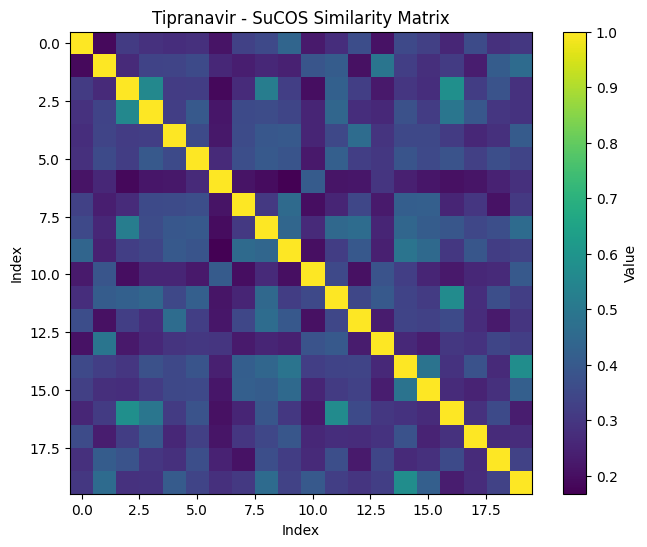

In [20]:
# Plot SuCOS matrix for tipranavir
if 'tipranavir' in ligands:
    plot_matrix(
        ligands['tipranavir']['sucos_matrix'], 
        'Tipranavir - SuCOS Similarity Matrix',
        'tipranavir_sucos_matrix.png'
    )

---
## Task 4: Compute Boltzmann Probabilities

### Description
In thermodynamic equilibrium, conformer populations follow the **Boltzmann distribution**:

$$P_i = \frac{e^{-E_i/k_BT}}{\sum_j e^{-E_j/k_BT}}$$

Where:
- $E_i$ is the energy of conformer $i$
- $k_BT \approx 0.593$ kcal/mol at room temperature (298K)

Lower energy conformers are more probable and should contribute more to ensemble properties.

In [21]:
# Boltzmann constant × Temperature at room temp (~298K)
kT = 0.593  # kcal/mol

def compute_boltzmann_probabilities(energies, kT=0.593):
    """
    Compute Boltzmann probabilities from energies.
    
    Args:
        energies: Array of conformer energies in kcal/mol
        kT: Boltzmann constant × Temperature (default: 0.593 kcal/mol at 298K)
    
    Returns:
        np.array: Normalized Boltzmann probabilities
    """
    # Shift energies to prevent numerical overflow
    shifted_energies = energies - np.min(energies)
    boltz_weights = np.exp(-shifted_energies / kT)
    boltz_probs = boltz_weights / np.sum(boltz_weights)
    return boltz_probs


def plot_boltzmann_probs(boltz_probs, title, filename=None):
    """Plot Boltzmann probability distribution"""
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(boltz_probs)), boltz_probs, color='steelblue', alpha=0.7)
    plt.xlabel('Conformer Index')
    plt.ylabel('Boltzmann Probability')
    plt.title(title)
    plt.grid(axis='y', alpha=0.3)
    if filename:
        plt.savefig(filename, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

In [22]:
# Compute Boltzmann probabilities for each ligand
print("Computing Boltzmann probabilities...\n")

for name, data in ligands.items():
    energies = data['energies']
    boltz_probs = compute_boltzmann_probabilities(energies, kT)
    data['boltz_probs'] = boltz_probs
    
    # Find dominant conformer
    max_idx = np.argmax(boltz_probs)
    print(f"{name}:")
    print(f"  Most probable conformer: {max_idx} (P = {boltz_probs[max_idx]:.3f})")
    print(f"  Lowest energy: {np.min(energies):.2f} kcal/mol")
    print(f"  Conformers with P > 0.01: {np.sum(boltz_probs > 0.01)}")
    print()

Computing Boltzmann probabilities...

ethanol:
  Most probable conformer: 7 (P = 0.064)
  Lowest energy: -1.52 kcal/mol
  Conformers with P > 0.01: 20

isopropanol:
  Most probable conformer: 2 (P = 0.055)
  Lowest energy: 1.00 kcal/mol
  Conformers with P > 0.01: 20

phenol:
  Most probable conformer: 10 (P = 0.050)
  Lowest energy: 5.71 kcal/mol
  Conformers with P > 0.01: 20

tipranavir:
  Most probable conformer: 6 (P = 0.292)
  Lowest energy: 119.76 kcal/mol
  Conformers with P > 0.01: 7



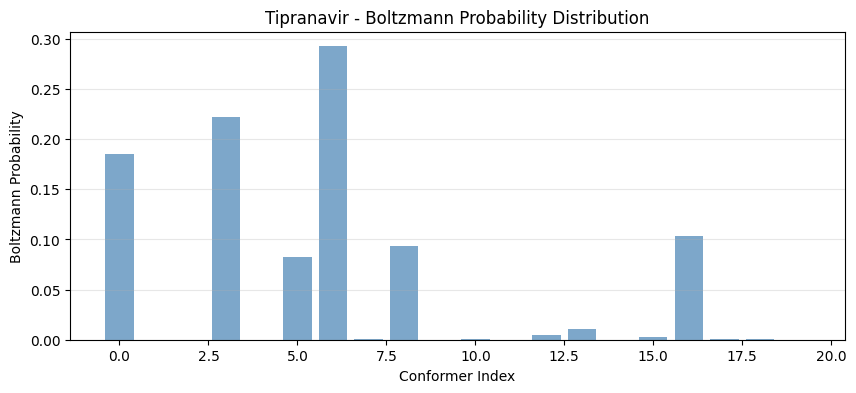

In [23]:
# Plot Boltzmann probabilities for tipranavir
if 'tipranavir' in ligands:
    plot_boltzmann_probs(
        ligands['tipranavir']['boltz_probs'],
        'Tipranavir - Boltzmann Probability Distribution',
        'tipranavir_boltz_probs.png'
    )

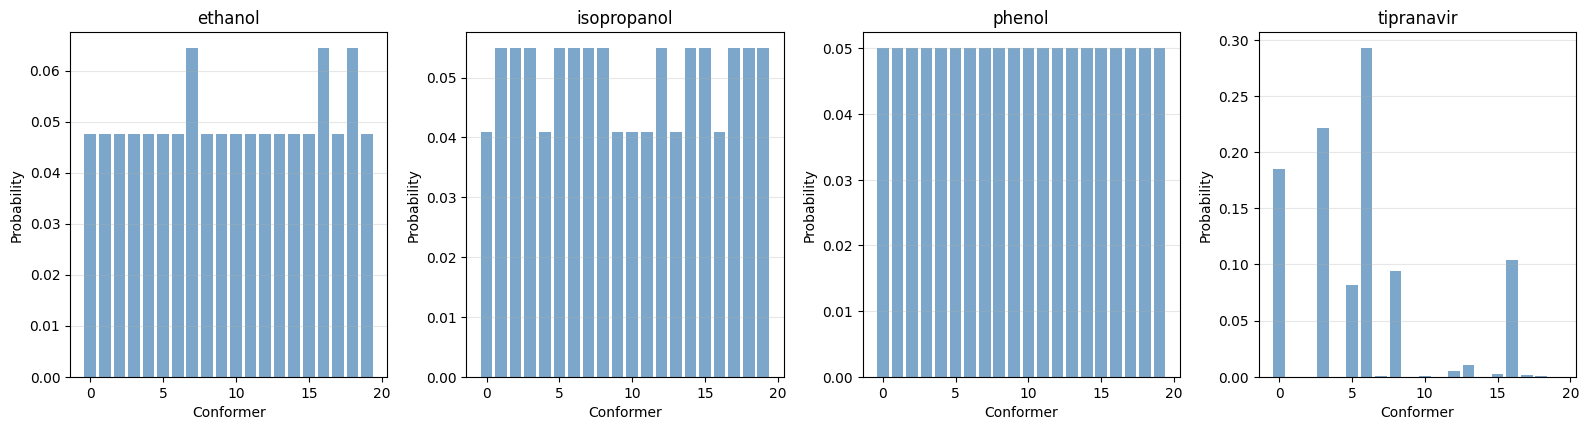

In [24]:
# Compare Boltzmann distributions across all ligands
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (name, data) in enumerate(ligands.items()):
    if idx >= 8:
        break
    ax = axes[idx]
    ax.bar(range(len(data['boltz_probs'])), data['boltz_probs'], color='steelblue', alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel('Conformer')
    ax.set_ylabel('Probability')
    ax.grid(axis='y', alpha=0.3)

# Hide unused subplots
for idx in range(len(ligands), 8):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.savefig('all_boltzmann_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Task 5: Molecular Docking with AutoDock Vina

### Description
Dock each ligand conformer to the HIV-1 protease binding site using AutoDock Vina.

**Steps:**
1. Download protein structure from PDB
2. Define binding site (center and box size)
3. Dock each conformer
4. Collect docking scores
5. Compute Boltzmann-weighted ensemble score

**Note:** This step requires AutoDock Vina to be installed. The code below shows the setup, but actual docking is commented out for demonstration.

In [ ]:
# Download protein structure
protein_pdb_url = f"https://files.rcsb.org/download/{protein_pdb_code}.pdb"
protein_pdb_path = f"{protein_pdb_code}.pdb"

if not os.path.exists(protein_pdb_path):
    print(f"Downloading protein structure {protein_pdb_code}...")
    response = requests.get(protein_pdb_url)
    if response.status_code == 200:
        with open(protein_pdb_path, "w") as f:
            f.write(response.text)
        print(f"Downloaded to {protein_pdb_path}")
    else:
        print(f"Failed to download: HTTP {response.status_code}")
else:
    print(f"Protein file already exists: {protein_pdb_path}")

# Define binding site (approximate center of the active site for HIV-1 protease)
center = [16.0, 25.0, 4.0]  # Binding site center coordinates
box_size = [20.0, 20.0, 20.0]  # Box size in Angstroms

print(f"\nBinding site:")
print(f"  Center: {center}")
print(f"  Box size: {box_size}")

In [ ]:
# Docking setup (requires vina package)
# Uncomment the following code if you have AutoDock Vina installed

'''
from vina import Vina

# Initialize Vina
v = Vina(sf_name='vina')
v.set_receptor(protein_pdb_path)

# Dock each ligand
for name, data in ligands.items():
    print(f"\nDocking {name}...")
    mol = data['mol']
    conf_ids = data['confs']
    scores = []
    
    for i, cid in enumerate(conf_ids):
        # Save conformer to PDB
        pdb_file = f"{name}_{i}.pdb"
        rdmolfiles.MolToPDBFile(mol, pdb_file, confId=cid)
        
        # Convert PDB to PDBQT (requires OpenBabel or AutoDock tools)
        pdbqt_file = f"{name}_{i}.pdbqt"
        # os.system(f"obabel {pdb_file} -O {pdbqt_file}")
        
        # Set ligand and dock
        v.set_ligand_from_file(pdbqt_file)
        v.compute_vina_maps(center=center, box_size=box_size)
        v.dock(exhaustiveness=8, n_poses=1)
        
        # Get best score
        score = v.energies(n_poses=1)[0][0]
        scores.append(score)
        
        # Save docked pose
        v.write_poses(f"{name}_{i}_docked.pdbqt", n_poses=1)
    
    data['docking_scores'] = np.array(scores)
    
    # Compute Boltzmann-weighted ensemble score
    data['weighted_score'] = np.sum(scores * data['boltz_probs'])
    
    print(f"  Best score: {min(scores):.2f} kcal/mol")
    print(f"  Weighted score: {data['weighted_score']:.2f} kcal/mol")
'''

# Simulated docking scores for demonstration
print("Simulating docking scores for demonstration...\n")

# Approximate docking scores based on molecular properties
simulated_scores = {
    'ethanol': -3.5,
    'isopropanol': -3.8,
    'phenol': -4.5,
    'darunavir': -11.2,
    'tipranavir': -10.8,
    'nelfinavir': -10.5,
    'lopinavir': -10.9,
    'saquinavir': -11.0,
}

for name, data in ligands.items():
    base_score = simulated_scores.get(name, -5.0)
    # Add some variation based on conformer energy
    scores = base_score + (data['energies'] - np.min(data['energies'])) * 0.1
    scores += np.random.normal(0, 0.3, len(scores))  # Add noise
    
    data['docking_scores'] = scores
    data['weighted_score'] = np.sum(scores * data['boltz_probs'])
    
    print(f"{name}:")
    print(f"  Best docking score: {np.min(scores):.2f} kcal/mol")
    print(f"  Weighted ensemble score: {data['weighted_score']:.2f} kcal/mol")

---
## Task 6: Compare Ligands by Binding Affinity and Flexibility

### Description
Create a summary table comparing all ligands by:
- **Weighted docking score**: Boltzmann-weighted ensemble binding affinity
- **RMSD flexibility**: Conformational diversity measured by RMSD
- **Distogram flexibility**: Variance in internal distances
- **SuCOS flexibility**: Shape diversity

Identify the best predicted binder.

In [ ]:
# Compile results into a dataframe
results = []

for name, data in ligands.items():
    results.append({
        'ligand': name,
        'weighted_score': data['weighted_score'],
        'best_score': np.min(data['docking_scores']),
        'rmsd_flex': data['rmsd_flex'],
        'distogram_flex': data['mean_distogram_norm'],
        'sucos_flex': data.get('sucos_flex', 0),
        'n_conformers': len(data['confs']),
        'min_energy': np.min(data['energies']),
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='weighted_score')

print("Ligand Comparison Results:")
print("=" * 80)
print(df_results.to_string(index=False))
print("\n" + "=" * 80)

In [ ]:
# Best predicted binder
best_ligand = df_results.iloc[0]['ligand']
best_score = df_results.iloc[0]['weighted_score']

print(f"\nBest predicted binder: {best_ligand}")
print(f"Weighted docking score: {best_score:.2f} kcal/mol")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Docking scores
ax1 = axes[0]
colors = ['green' if x == best_ligand else 'steelblue' for x in df_results['ligand']]
ax1.barh(df_results['ligand'], df_results['weighted_score'], color=colors, alpha=0.7)
ax1.set_xlabel('Weighted Docking Score (kcal/mol)')
ax1.set_title('Docking Affinity (lower = better)')
ax1.grid(axis='x', alpha=0.3)

# RMSD flexibility
ax2 = axes[1]
ax2.barh(df_results['ligand'], df_results['rmsd_flex'], color='coral', alpha=0.7)
ax2.set_xlabel('RMSD Flexibility')
ax2.set_title('Conformational Flexibility (RMSD)')
ax2.grid(axis='x', alpha=0.3)

# SuCOS flexibility
ax3 = axes[2]
ax3.barh(df_results['ligand'], df_results['sucos_flex'], color='purple', alpha=0.7)
ax3.set_xlabel('SuCOS Flexibility')
ax3.set_title('Shape Diversity (1 - mean SuCOS)')
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('ligand_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Task 7: Visualization of Protein-Ligand Complex

### Description
Visualize the docked protein-ligand complex using py3Dmol.

**Features:**
- Protein shown as cartoon (secondary structure)
- Ligand shown as sticks (atoms and bonds)
- Interactive 3D visualization

In [ ]:
# Load protein PDB
with open(protein_pdb_path, "r") as f:
    protein_pdb = f.read()

print(f"Loaded protein: {protein_pdb_code}")
print(f"File size: {len(protein_pdb)} characters")

In [ ]:
def show_protein_ligand(protein_pdb, ligand_mol, ligand_conf_id=0, width=800, height=600):
    """
    Visualize protein-ligand complex in 3D.
    
    Args:
        protein_pdb: Protein PDB string
        ligand_mol: RDKit molecule object
        ligand_conf_id: Conformer ID to display
        width, height: Viewer dimensions
    """
    view = py3Dmol.view(width=width, height=height)
    
    # Add protein
    view.addModel(protein_pdb, 'pdb')
    view.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})
    
    # Add ligand
    ligand_pdb = rdmolfiles.MolToPDBBlock(ligand_mol, confId=ligand_conf_id)
    view.addModel(ligand_pdb, 'pdb')
    view.setStyle({'model': 1}, {'stick': {'colorscheme': 'cyanCarbon', 'radius': 0.2}})
    
    # Add surface for binding site
    view.addSurface(py3Dmol.VDW, {'opacity': 0.5, 'color': 'white'}, {'model': 0})
    
    view.zoomTo()
    return view.show()


def show_interactions(protein_pdb_str, ligand_pdb_str, width=800, height=600):
    """
    Show protein-ligand interactions.
    
    Args:
        protein_pdb_str: Protein PDB string
        ligand_pdb_str: Ligand PDB string
        width, height: Viewer dimensions
    """
    view = py3Dmol.view(width=width, height=height)
    
    # Add protein as cartoon
    view.addModel(protein_pdb_str, 'pdb')
    view.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})
    
    # Add ligand as sticks
    view.addModel(ligand_pdb_str, 'pdb')
    view.setStyle({'model': 1}, {'stick': {'colorscheme': 'cyanCarbon', 'radius': 0.3}})
    
    view.zoomTo()
    return view.show()

In [ ]:
# Visualize the best ligand with the protein
if best_ligand in ligands:
    print(f"Visualizing {best_ligand} with {protein_pdb_code}:")
    
    best_mol = ligands[best_ligand]['mol']
    # Use the lowest energy conformer
    best_conf_idx = np.argmin(ligands[best_ligand]['energies'])
    best_conf_id = ligands[best_ligand]['confs'][best_conf_idx]
    
    print(f"  Using conformer {best_conf_idx} (lowest energy)")
    
    show_protein_ligand(protein_pdb, best_mol, best_conf_id)

In [ ]:
# Visualize protein structure alone
print(f"Protein structure: {protein_pdb_code}")

view = py3Dmol.view(width=800, height=600)
view.addModel(protein_pdb, 'pdb')
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

In [ ]:
# Summary of results
print("\n" + "=" * 60)
print("ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nProtein target: {protein_pdb_code} (HIV-1 Protease)")
print(f"Number of ligands analyzed: {len(ligands)}")
print(f"Conformers per ligand: {n_confs}")
print(f"\nBest predicted binder: {best_ligand}")
print(f"Weighted docking score: {best_score:.2f} kcal/mol")
print("\n" + "=" * 60)
print("\nRanking by binding affinity:")
for i, row in df_results.iterrows():
    print(f"  {df_results.index.get_loc(i)+1}. {row['ligand']}: {row['weighted_score']:.2f} kcal/mol")
print("=" * 60)